In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('Google_Stock_Price_Train.csv',thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


Text(0, 0.5, 'Stock Volume')

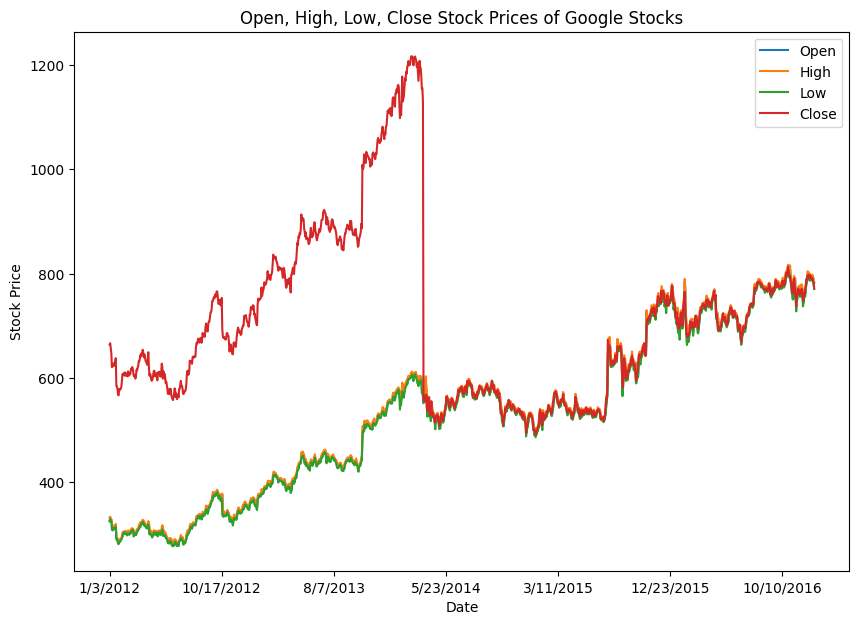

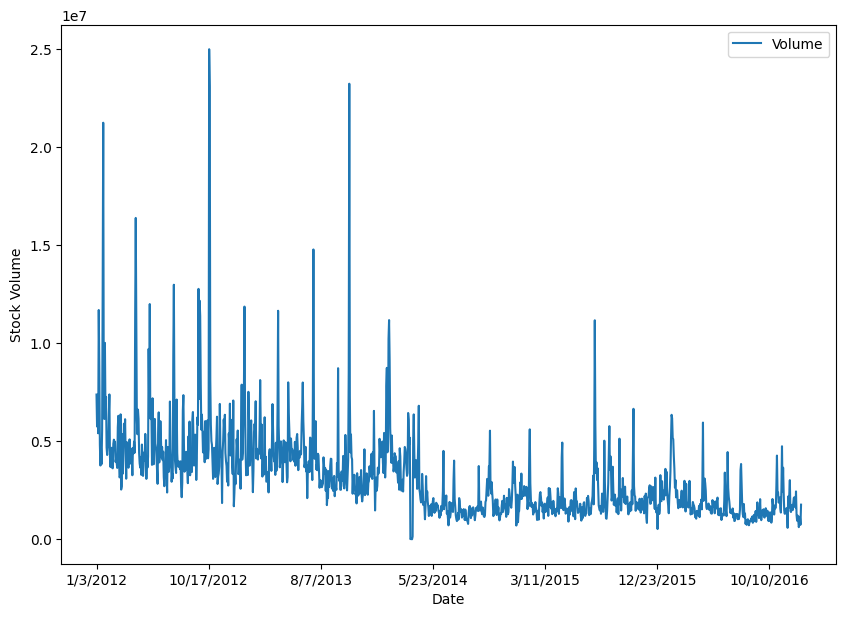

In [3]:
ax1 = data.plot(x="Date", y=["Open", "High", "Low", "Close"], figsize=(10,7),title='Open, High, Low, Close Stock Prices of Google Stocks')
ax1.set_ylabel("Stock Price")

ax2 = data.plot(x="Date", y=["Volume"],  figsize=(10,7))
ax2.set_ylabel("Stock Volume")

In [4]:
data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


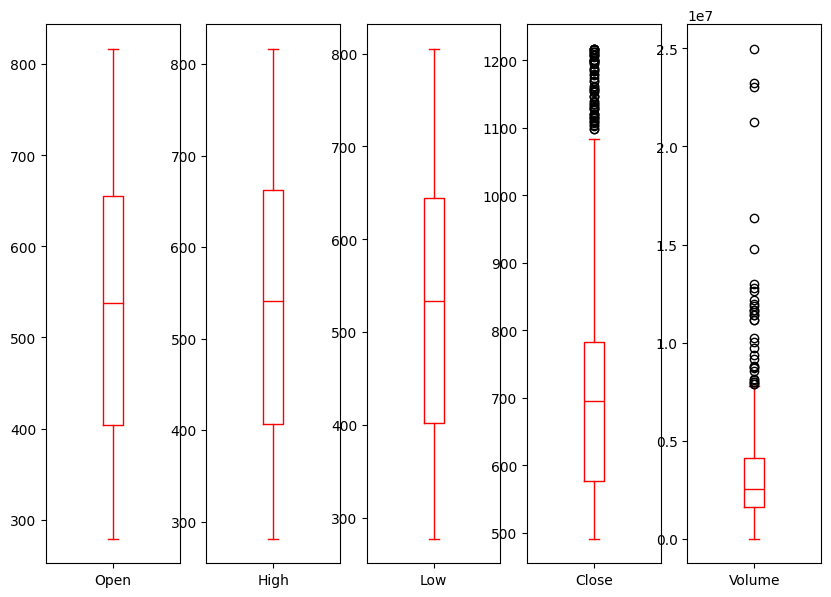

In [5]:
data[['Open','High','Low','Close','Volume']].plot(kind='box', layout=(1,5), subplots=True, sharex=False, sharey=False, figsize=(10,7),color='red')
plt.show()

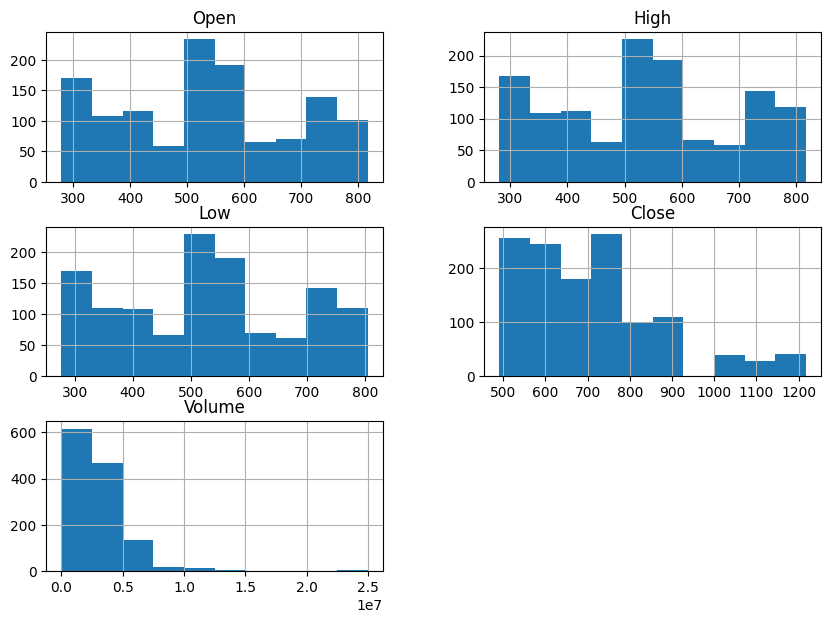

In [6]:
data.hist(figsize=(10,7))
plt.show()

In [7]:
scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))

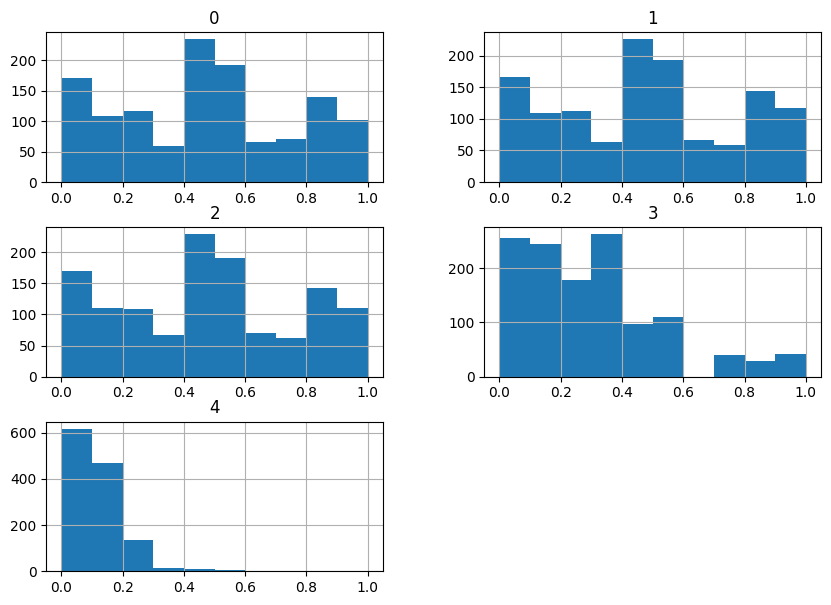

In [8]:
scaled_data.hist(figsize=(10,7))
plt.show()

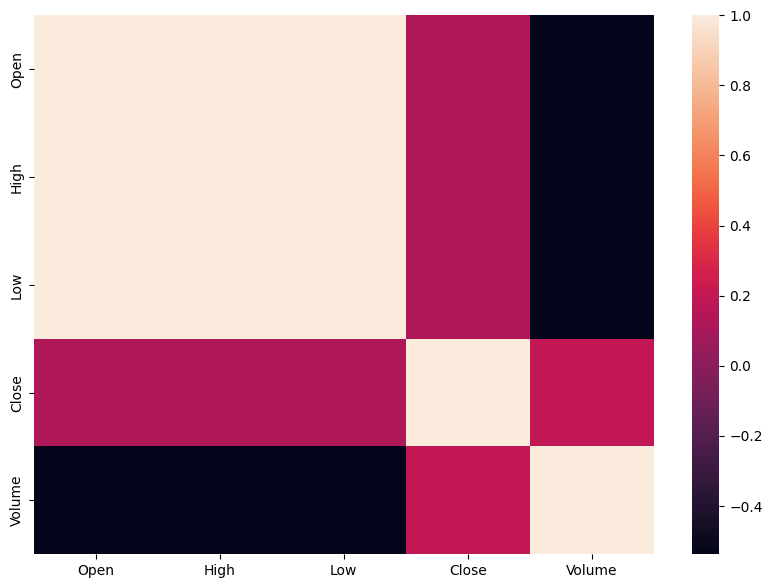

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(data.drop("Date", axis=1).corr())
plt.show()

In [10]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [11]:
def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x = []
    y = []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window (this indexing is for 2 features vala data only)
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)

In [12]:
n_steps = 60

scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [13]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)

In [14]:
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [15]:
y = y[:, 0]
y.shape

(1198,)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [17]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 612)            │     1,505,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        30,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,540,281 (5.88 MB)

 Trainable params: 1,540,281 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [22]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(x_test, y_test))#increase epoch as needed to 250

Epoch 1/50
30/30 - 1s - 20ms/step - loss: 0.0034 - mae: 0.0318 - val_loss: 0.0037 - val_mae: 0.0349
Epoch 2/50
30/30 - 1s - 17ms/step - loss: 0.0035 - mae: 0.0341 - val_loss: 0.0039 - val_mae: 0.0363
Epoch 3/50
30/30 - 1s - 20ms/step - loss: 0.0035 - mae: 0.0322 - val_loss: 0.0037 - val_mae: 0.0346
Epoch 4/50
30/30 - 1s - 17ms/step - loss: 0.0034 - mae: 0.0319 - val_loss: 0.0037 - val_mae: 0.0357
Epoch 5/50
30/30 - 1s - 24ms/step - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0039 - val_mae: 0.0353
Epoch 6/50
30/30 - 1s - 20ms/step - loss: 0.0035 - mae: 0.0335 - val_loss: 0.0037 - val_mae: 0.0356
Epoch 7/50
30/30 - 1s - 20ms/step - loss: 0.0035 - mae: 0.0328 - val_loss: 0.0038 - val_mae: 0.0375
Epoch 8/50
30/30 - 1s - 19ms/step - loss: 0.0035 - mae: 0.0323 - val_loss: 0.0035 - val_mae: 0.0370
Epoch 9/50
30/30 - 1s - 17ms/step - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0035 - val_mae: 0.0349
Epoch 10/50
30/30 - 1s - 17ms/step - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0037 - val_mae: 0.0347

<Axes: >

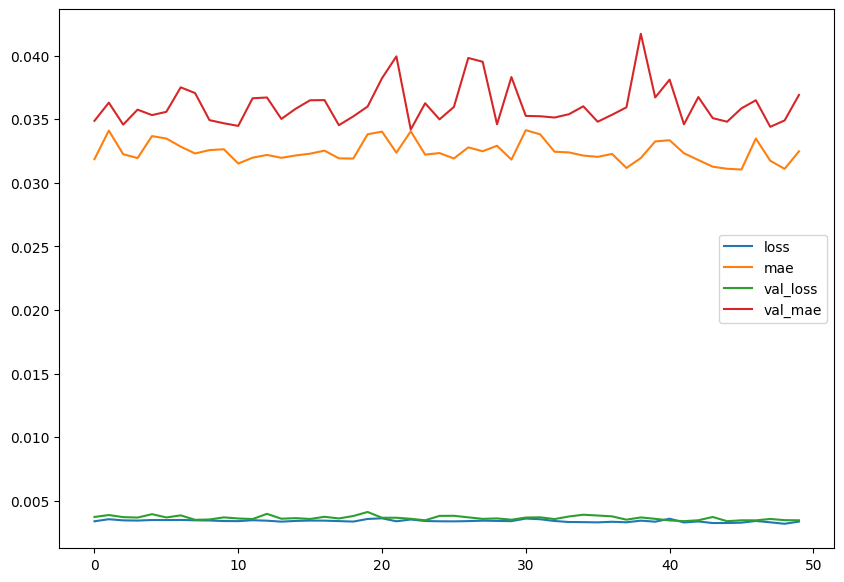

In [23]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [24]:
model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0361 


[0.0034595883917063475, 0.03690480440855026]

In [25]:
predictions = model.predict(x_test)
predictions.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


(240, 1)

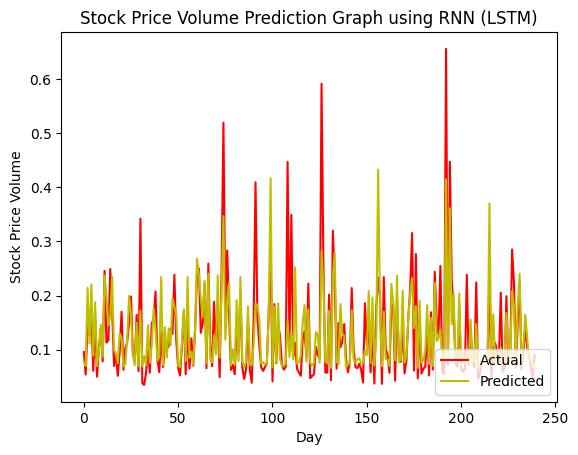

<Figure size 1000x700 with 0 Axes>

In [26]:
plt.plot(y_test, c = 'r')
plt.plot(predictions, c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'], loc = 'lower right')
plt.figure(figsize=(10,7))
plt.show()



Time Series Prediction with RNNs (LSTMs) and Code Explanation
Predicting future stock prices from historical data is a time series problem. Traditional machine learning struggles with the inherent sequential nature of this data, where past values influence future ones.

Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) Networks:

RNNs are designed for sequential data, using a "memory" to consider past inputs. However, standard RNNs can struggle with long sequences due to vanishing/exploding gradients. LSTMs are a specialized RNN architecture that overcomes this using "gates" to control information flow within their memory cells, allowing them to learn long-term dependencies.

Applying LSTMs to Stock Prices (as demonstrated in your code):

Your Python code implements a stock price prediction system using an LSTM network. Here's a breakdown of its key steps:

Data Loading and Exploration: The code begins by loading the Google stock price dataset using pandas. It then visualizes the 'Open', 'High', 'Low', 'Close' prices and 'Volume' over time, checks for missing values, and explores the distribution and potential outliers in the data using box plots and histograms.

Data Preprocessing:

Numerical features (excluding 'Date') are scaled using MinMaxScaler to the range [0, 1]. This helps in faster and more stable training of the neural network.
The 'Open', 'High', and 'Low' columns are dropped, focusing the prediction on the 'Close' price and 'Volume'.
The split_seq_multivariate function transforms the sequential data into input-output pairs. It creates sequences of the past n_steps (here, 60) days of 'Close' price and 'Volume' as input (x), and the corresponding next day's 'Close' price as the target (y).
Data Splitting: The prepared data is split into training and testing sets using train_test_split. The model learns from the training data and its performance is evaluated on the unseen testing data.

Model Building: A sequential LSTM model is created using Keras/TensorFlow. It consists of:

An LSTM layer with 612 units, taking sequences of 60 time steps with 2 features as input.
Several Dense (fully connected) layers with ReLU activation to learn complex relationships.
A final Dense layer with a single output unit to predict the next day's stock volume.
Model Compilation and Training: The model is compiled with the Adam optimizer, Mean Squared Error (MSE) as the loss function, and Mean Absolute Error (MAE) as 1  a metric. It is then trained on the training data using model.fit() for a specified number of epochs. The training progress, including loss on the training and validation sets, is recorded.


Model Evaluation: The trained model is evaluated on the test data using model.evaluate() to assess its prediction accuracy.

Prediction and Visualization: The model makes predictions on the test data using model.predict(). The actual and predicted stock volumes are then plotted to visually compare the model's performance.

In essence, the code:

Loads and prepares historical Google stock data.
Creates sequences of past 'Close' price and 'Volume' to predict future 'Volume'.
Builds and trains an LSTM neural network to learn these relationships.
Evaluates the model's ability to predict future stock volume on unseen data.
Visualizes the model's predictions against the actual values.
This demonstrates a practical application of LSTMs for time series forecasting in the context of stock market analysis.